---
title: "Gibbs sampler as a product"
excerpt: "Awesome excerpt"
---

$$
x^2
$$

$x^2$

$$
\begin{align}
x &=2 \\
y &= 3
\end{align}
$$

My summer project at Civis Analytics this summer is to derive and implement a Gibbs sampler for one of their core algorithm. While I've had done several Gibbs samplers in my academic work, in those situations I knew that a solution exists, and the Gibbs sampler is written as a minimum viable product with little regard paid to maintainability and robustness. Now that my code will be used to make business decision worth many dollars, I have to make sure that my code is well tested and easy for other engineers to read and contribute.

At the heart of the approach is the Testing MCMC code framework by Roger Grosse. As the paper lays out, testing traditional MCMC code is difficult because:

- The output is probabilistic
- With regularization and prior the result can be reasonable even when the code is wrong
- When the code is right the result can still be wrong because the density we try to sample from is just difficult.

With all of that complications, the signal of a test quickly vanishes into the noise. Furthermore, exarcebating the problem is that the Gibbs sampler is frequently taught in school as a giant loop updating one parameter each. While such implementation facilitates pedagogy by keeping only the materials essential to the Gibbs sampler, it does not make use of useful engineering practices.

Consider a Gibbs sampler for a univariate normal model:

**Likelihood**

$$Data = Y_1, \dots, Y_n \sim i.i.d. N(\theta, \sigma^2)$$

The parameters are $(\theta, \sigma^2)$, the data is a vector of $Y_i$

**Prior**

$$
\begin{align}
p(\theta) &\sim N(\mu_0, \tau^2_0) \\
p(\sigma^2) &\sim Inverse-Gamma(\nu_0 / 2, \nu_0 \sigma^2_0 / 2) 
\end{align}
$$

**Full conditional**

$$
\begin{align} 
p(\theta | \tilde \sigma^2, Data) &= N(\mu_n, \tau^2_n) \\
p( \sigma^2 | \theta, Data) &= Inverse-Gamma(\frac{\nu_n}{2}, \frac{\nu_n \sigma_n^2(\theta)}{2}) 
\end{align} 
$$

where

$$
\begin{align} 
\tau_n^2 = \frac{1}{\frac{1}{\tau_0^2} + \frac{n}{\sigma^2}} \qquad &\text{and} \qquad \mu_n = \frac{\frac{\mu_0}{\tau_0^2} + \frac{n\bar y}{\sigma^2}}{\frac{1}{\tau_0^2} + \frac{n}{\sigma^2}} \\
\nu_n = \nu_0 + n \qquad &\text{and} \qquad \sigma^2_n(\theta) = \frac{1}{\nu_n} \left[ \nu_0\sigma_0^2 + n \frac{\sum (y_i - \theta)^2}{n}\right]
\end{align}
$$

Then the Gibbs sampler is a big for-loop:

for s in range(S):
- Draw $\theta$ from $p(\theta_s | \sigma^2_{s-1}, data)$
- Draw $\sigma^2$ from $p(\sigma^2_s | \theta_s, data)$

Now, how do we know whether we have derived this Gibbs sampler correctly? One approach is to set the parameter values ourselves and see whether the Gibbs sampler is able to recover it. (A colleague told me that this is called an oracle test, which doesn't seem widely used according to Google, but definitely should!)

In [11]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from plotnine import *

true_theta = 2
true_sigma2 = 3.5
y = np.random.normal(true_theta, np.sqrt(true_sigma2), size = 100)

In [16]:
prior_mu_0 = 0
prior_tau2_0 = 1
prior_nu_0 = 1
prior_sigma2_0 = 0.01

In [18]:
n = len(y)
ybar = np.mean(y)

# Initialize storage
S = 1000 # Number of samples that we'll draw from the Gibbs sampler
res_theta = np.empty(S)
res_sigma2 = np.empty(S)

# Starting value as the sample variance and mean
res_sigma2[0] = y.var()
res_theta[0] = ybar

# Gibbs sampler -- big loop
for s in range(1, S):
# Full conditional for theta
    sigma2 = res_sigma2[s - 1] # Get the current value of sigma2

    tau2_n = 1 / (1 / prior_tau2_0 + n / sigma2)
    mu_n = (prior_mu_0 / prior_tau2_0 + n * ybar / sigma2) / (1 / prior_tau2_0 + n / sigma2)

    # Generate and save theta
    res_theta[s] = scipy.stats.norm(mu_n, np.sqrt(tau2_n)).rvs()

    # Full conditional for sigma
    theta = res_theta[s] # Get the current value of theta

    nu_n = prior_nu_0 + n
    nu_sigma2_n = prior_nu_0 * prior_sigma2_0 + sum((y - theta) ** 2)
    res_sigma2[s] = 1 / scipy.stats.gamma(nu_n / 2, scale=2 / nu_sigma2_n).rvs()

In [2]:
y = np.array([1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08])
theta_samples, sigma2_samples = gibbs_sampler(y = y, S = 1000,
                   mu_0 = 1.9, tau2_0 = 0.95 ** 2,
                   sigma2_0 = 0.01, nu_0 = 1)

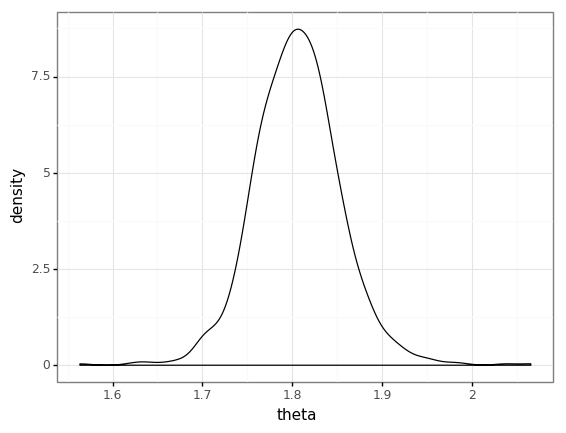

<ggplot: (289204186)>

In [3]:
ggplot(pd.DataFrame({'theta':theta_samples})) + geom_density(aes('theta')) + theme_bw()

# Okay, but how do we test that big foor loop?

- It's probabilitistic -- so there is no expected outcome for unit test (e.g. ```assert actual_outcome == expected_outcome```)
- It's slow -- so we can't re-run the test suite everytime we make a small change
- It's not modular -- failures can come from doing the math wrong, from coding any of the conditionals wrong

# Solution 1: Unit test your conditional

For any value of $\theta, \theta'$

\begin{align}
\frac{p(\theta | z)}{p(\theta' | z)} &= \frac{p(\theta | z)p(z)}{p(\theta' | z)p(z)} \\
&= \frac{p(\theta, z)}{p(\theta', z)}
\end{align}

The LHS is hard to get right, but the RHS is very easy to get right (indeed, $p(\theta, z) = p(z | \theta) p(\theta)$). So the RHS can be the easy-to-verify "expected outcome" that we test the LHS against in a unit test.

This strategy also suggests that we modularize our MCMC code, separating each conditional $p(\theta | z)$ into its own function. This way we can unit test each conditional.

In [4]:
class State(object):
    def __init__(self, theta, sigma2):
        self.theta = theta
        self.sigma2 = sigma2

class Model(object):
    def __init__(self, theta_prior, sigma2_prior):
        self.theta_prior = theta_prior
        self.sigma2_prior = sigma2_prior

    # Conditional distribution of theta
    def cond_theta(self, state, data):
        n = len(data)
        mean_prior = self.theta_prior.args[0]
        variance_prior = self.theta_prior.args[1] ** 2

        variance_post = 1 / (1 / variance_prior + n / state.sigma2)
        mean_post = variance_post * (mean_prior / variance_prior + n * data.mean() / state.sigma2)
        return scipy.stats.norm(mean_post, np.sqrt(variance_post))

    # Conditional distribution of theta
    def cond_sigma2(self, state, data):
        n = len(data)
        shape_prior = self.sigma2_prior.kwds['a']
        scale_prior = self.sigma2_prior.kwds['scale']

        shape_post = shape_prior + n / 2
        scale_post = scale_prior + np.sum((data - state.theta) ** 2) / 2
        return scipy.stats.invgamma(shape_post, scale=scale_post)

    # One Gibbs step is just iterating through the conditionals
    def gibbs_step(self, state, data):
        state.theta = self.cond_theta(state, data).rvs()
        state.sigma2 = self.cond_sigma2(state, data).rvs()

In [5]:
import pytest

@pytest.fixture
def random_model():
    theta_prior = scipy.stats.norm(np.random.uniform(), np.random.uniform())
    sigma2_prior = scipy.stats.invgamma(a=np.random.uniform(),
                                        scale=np.random.uniform())
    return Model(theta_prior=theta_prior,
                 sigma2_prior=sigma2_prior)

@pytest.fixture
def random_state():
    return State(np.random.uniform(), np.random.uniform())

@pytest.fixture
def random_data():
    return np.random.normal(size=10)

def test_cond_theta(random_model, random_state, random_data):

    cond = random_model.cond_theta(random_state, random_data)
    new_state = copy.deepcopy(random_state)
    new_state.theta = np.random.uniform()

    assert np.allclose(cond.logpdf(new_state.theta) - cond.logpdf(state.theta),
                       random_model.joint_log_p(new_state, data) - \
                       random_model.joint_log_p(state, data))